In [10]:
from model_complex import Calibration
import matplotlib.pyplot as plt


d = Calibration('total', 1, 1)
epid, simulation_func, data = d.calibrate('spb', './', '11-01-2018', '5-27-2019')


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [9]:
epid

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

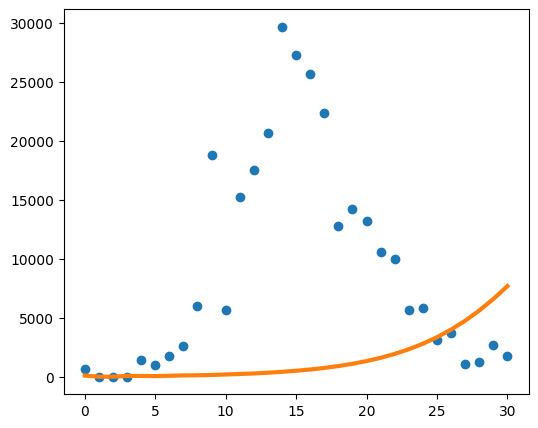

In [11]:

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
start_day = 15    
posterior = epid.posterior.stack(samples=("draw", "chain"))
ax.plot(data, "o")
ax.plot(simulation_func(None, posterior["alpha"].mean(), posterior["beta"].mean()), 
                linewidth=3)
